# DS-поток, весна 2025
## Задание ADL.2
### Мультимодальные модели.

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.

**Баллы за задание:**

* Данные и датасет &mdash; 20 баллов;
* Реализация и обучение модели &mdash; 80 баллов.

In [ ]:
# Bot check

# HW_ID: ds_adl2
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [48]:
# установим нужные библиотеки
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [49]:
import json
import random
from pathlib import Path
from datasets import load_dataset
from transformers import AutoProcessor, DataCollatorWithPadding, AutoModelForCausalLM, GPT2Tokenizer, GPT2LMHeadModel, CLIPModel, TrainingArguments, Trainer
from tokenizers.processors import TemplateProcessing
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_model, save_model
# from google.colab import drive  # я использую кэгл
# drive.mount('/content/drive')

В этом домашнем задании мы снова будем решать задачу ImageCaptioning'a. На занятии вы познакомились с мультимодальными моделями, поэтому теперь решать задачу мы будем уже с помощью современных трансформеров.

## Данные

В качестве датасета будем использовать аннотированные мемы с Reddit'a. Более подробно можно узнать в [статье](https://arxiv.org/pdf/2305.13703.pdf) или на [github](https://github.com/eujhwang/meme-cap).

Мы заранее положили данные на [Google Drive](https://drive.google.com/drive/folders/1thN01pTU-bFQBl2VeZv2m5h8J6py0hM7?usp=sharing) для более удобного использования в Colab.



In [50]:
# !ls /content/drive/MyDrive/mem_captions

In [51]:
# !mkdir data
# !cp -r /content/drive/MyDrive/mem_captions/* ./data/
# !ls data

Распакуем архив с картинками.

In [52]:
# !unzip data/memes.zip  -d data/

In [53]:
!cp -r /kaggle/input/mem-captions* /kaggle/working/
data_path = Path("/kaggle/working/mem-captions/mem_captions").resolve()
images_path, trainval_data_path = data_path / "memes/memes", data_path / "memes-trainval.json"

Загрузите и посмотрите на пример данных, которые находятся в `memes-trainval.json`.

In [54]:
with open(trainval_data_path) as f:
    trainval_data = json.load(f)

In [55]:
trainval_data[13]

{'category': 'memes',
 'img_captions': ['Cat is riding a motorcycle',
  'A determined cat with its legs spread out while on a motorcycle that is off the ground.'],
 'meme_captions': ['Meme poster is saying their cat moves much more quickly to answer them when they call it with a certain sound rather than by its name.',
  'The person who wrote the post is saying cats are unpredictable.'],
 'title': 'The Fast and the Feline',
 'url': 'https://i.redd.it/pjdnmlre66841.jpg',
 'img_fname': 'memes_eiide7.png',
 'metaphors': [{'metaphor': 'a motorcycle', 'meaning': 'moving fast'},
  {'metaphor': 'riding', 'meaning': 'moving fast'},
  {'metaphor': 'a motorcycle', 'meaning': 'moving fast'},
  {'metaphor': 'the ground', 'meaning': 'not related to the meme context'},
  {'metaphor': 'spread', 'meaning': 'not related to the meme context'}],
 'post_id': 'eiide7'}

Как видим, в данных содержится много информации. Мы же ограничимся только использованием `mem_captions`. Это поле содержит **список** текстовых описаний для мема. Обратите внимание, что в списке может быть > 1 описания!

Теперь создадим объект датасета. Пока мы имеем картинки, лежащие в отдельной директории и некоторый json с текстовыми описаниями. Мы воспользуемся возможностью создать ImageFolder-like датасет с использованием `datasets`. Директория с картинками у нас уже есть, остается добавить к ней файл `metadata.jsonl`, который бы содержал описания для соотвествующих изображений.

In [56]:
trainval_images = set()  # сохраним, какие картинки лежат в trainval. Тест мы использовать не будем
with (images_path / "metadata.jsonl").open("w+", encoding="utf-8") as f:
    for item in trainval_data:  # x в поле file_name содержит имя файла, а в поле text - список текстовых описаний
        x = {"file_name":item['img_fname'],"text":item['meme_captions']}
        f.write(json.dumps(x) + "\n")
        trainval_images.add(item["img_fname"])

Т.к. мы не будем использовать тестовую подвыборку, то просто удалим соответствующие картинки из директории.

In [57]:
for x in images_path.iterdir():
    if x.name.endswith(".png") and (x.name not in trainval_images):
        x.unlink()

Теперь загрузим наш датасет и посмотрим на пример данных. Обратите внимание, что картинки уже загружены в виде `PIL.Image`.

In [58]:
dataset = load_dataset("imagefolder", data_dir=images_path)

Resolving data files:   0%|          | 0/5824 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

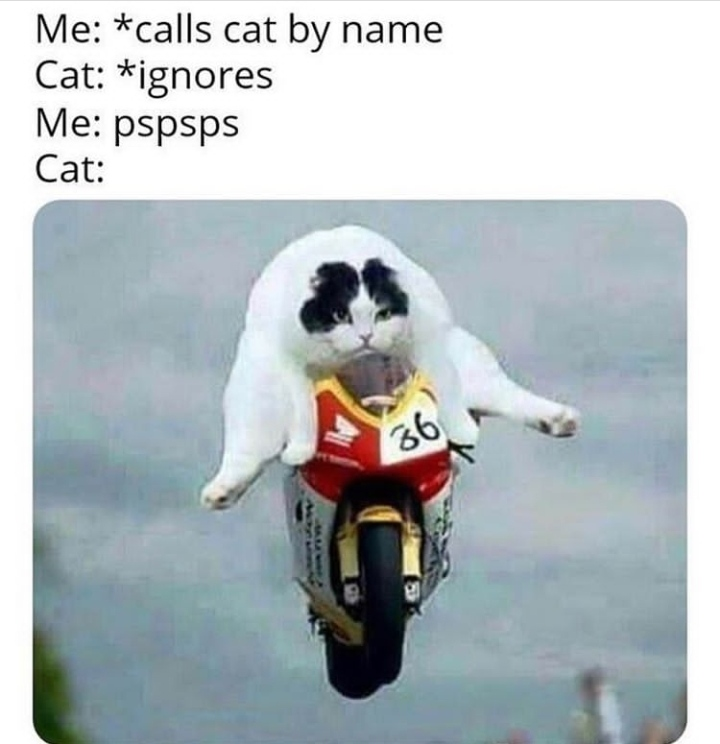

In [59]:
dataset["train"][13]["image"]

In [60]:
dataset["train"][13]["text"]

['Meme poster is saying their cat moves much more quickly to answer them when they call it with a certain sound rather than by its name.',
 'The person who wrote the post is saying cats are unpredictable.']

Для того, чтобы правильно обработать данные для нашей модели в `transformers` существует абстракция `Processor`. `Processor` предназначен для обработки входных данных разных модальностей. Например, в нашем случае мы должны отдельно токенизировать текст и обработать картинку. Обычно такой обработчик привязан к мультимодальной модели.


В нашем случае мы будем сами строить такую мультимодальную модель. В ее основе будут лежать уже предобученные CLIP и GPT2. О том, как устроена модель, мы поговорим чуть позже, а пока нам достаточно осознать, что картинку мы должны обработать Processor'ом от CLIP'a. Текст же токенизируем с помощью токенизатора GPT2.

In [61]:
image_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

Посмотрим на пример работы. Как видим, мы с легкостью получили тензоры, которые можно отправить на вход модели.

In [62]:
item = dataset["train"][13]
image_processor(images=item["image"], return_tensors="pt")  # картинка на входе – это тензор (c, h, w)

{'pixel_values': tensor([[[[1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          ...,
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303],
          [1.9303, 1.9303, 1.9303,  ..., 1.9303, 1.9303, 1.9303]],

         [[2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          ...,
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749],
          [2.0749, 2.0749, 2.0749,  ..., 2.0749, 2.0749, 2.0749]],

         [[2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459, 2.1459,  ..., 2.1459, 2.1459, 2.1459],
          [2.1459, 2.1459

In [63]:
tokenizer(item["text"], padding=True)

{'input_ids': [[13579, 68, 11968, 318, 2282, 511, 3797, 6100, 881, 517, 2952, 284, 3280, 606, 618, 484, 869, 340, 351, 257, 1728, 2128, 2138, 621, 416, 663, 1438, 13], [464, 1048, 508, 2630, 262, 1281, 318, 2282, 11875, 389, 22900, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

Теперь вам предстоит написать простой map-style PyTorch Dataset, который по индексу обработает каждую картинку и описание, а также вернет их нужном для модели формате:
* для текста необходимы `input_ids` и `attention_mask`, текст обрабатываем с помощью токенизатора от GPT2
* картинка преобразуется в `pixel_values`, это тензор размерности `(C, H, W)`, который получается посли применения `Processor`'a от CLIP'a.

Напомним, что некоторые сэмплы содержат несколько описаний. Рекомендуется выбирать просто случайное.

Заметим также, что к тексту разумно добавить спец. токены типа `<|bos|>`, `<|eos|>`. Токенизатор от GPT2 имеет только один специальный токен, а именно `<|endoftext|>`. Он используется для разделения текстов документов во время предобучения. Его можно использовать как токен начала / конца описания, а можно добавить такие токены отдельно, мы уже делали это ранее.

In [64]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, image_processor, tokenizer):
        self.dataset, self.image_processor, self.tokenizer = dataset, image_processor, tokenizer
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        item = self.dataset[idx]
        img = self.image_processor(images=item["image"], return_tensors="pt").pixel_values
        text = random.choice(item["text"])
        enc = self.tokenizer(text, return_tensors="pt", add_special_tokens=True, padding=True, truncation=True)
        return {"pixel_values":img, "input_ids":enc["input_ids"].squeeze(), "attention_mask":enc["attention_mask"].squeeze()}

Кажется мы совсем забыли про валидацию. Разделите выборку на обучающую и валидационную, выделив под валидацию около 10%.



In [65]:
split = dataset["train"].train_test_split(test_size=0.1)
train_dataset = ImageCaptioningDataset(split["train"], image_processor, tokenizer)
val_dataset = ImageCaptioningDataset(split["test"], image_processor, tokenizer)

Проверим размерности входных тензоров.

In [66]:
item = train_dataset[0]
for k, v in item.items():
    print(k,v.shape)

pixel_values torch.Size([1, 3, 224, 224])
input_ids torch.Size([20])
attention_mask torch.Size([20])


Определим даталоадер.

In [67]:
data_collator = DataCollatorWithPadding(tokenizer)  # используем паддинг для описаний разной длины
train_dataloader = DataLoader(train_dataset, shuffle=True, collate_fn=data_collator, batch_size=256)  # batch_size !!!
val_dataloader = DataLoader(val_dataset, shuffle=False, collate_fn=data_collator, batch_size=256)

Проверим, что все работает.

In [68]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape)

pixel_values torch.Size([256, 1, 3, 224, 224])
input_ids torch.Size([256, 50])
attention_mask torch.Size([256, 50])


In [69]:
tokenizer.decode(batch["input_ids"][0])

'Meme poster is trying to convey that Wikipedia has been asking for money for years and is upset that you will pay to verify social media instead.<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>'

## Модель

Теперь напишем код модели. Мы обучим свою модель для ImageCaptioning самостоятельно, но схематично она будет напоминать [GIT](https://arxiv.org/abs/2205.14100) (Generative Image-to-text Transformer) от Microsoft. Схема архитектуры изображена на картинке. Общая идея же скорее всего вам известна с занятия: для того, чтобы научить LLM работать с картинкой, нам необходимо добавить отдельный энкодер для изображений.

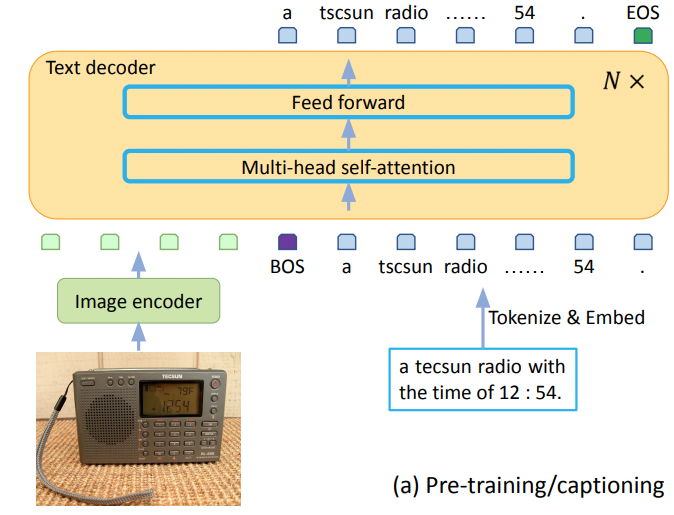


Теперь обсудим несколько деталей.

* Входное изображение обрабатывается заранее предобученным в contrastive-lerning манере энкодером. В нашем случае будем использовать базовый [CLIP](https://huggingface.co/openai/clip-vit-base-patch32).

* Извлеченный из CLIP'a вектор обрабатывается маппером на основе простого MLP, который отобразит вектор фичей картинки в последовательность эмбддингов для GPT2.

* Полученные эмбеддинги изображения конкатенируются с текстовыми эмбеддингами, и все это подается на вход обычного декодера трансформера. В нашем случае мы будем использовать маленькую предобученную языковую модель GPT2 Small.
* Модель предобучается авторегрессионно предсказывать **текстовое описание**.

Теперь реализуем основные части модели.

In [100]:
class ImageEncoder(nn.Module):
    """ Кодирует изображение и возвращает его эмбеддинг. """
    def __init__(self, model_name_or_path, device="cuda"):
        super(ImageEncoder, self).__init__()
        self.device = device  # загрузим модель через CLIPModel.from_pretrained. Нужна только картиночная часть, то есть vision_model
        self.model = CLIPModel.from_pretrained(model_name_or_path).vision_model.to(device)
    def forward(self, image):
        return self.model(image).pooler_output  # image – тензор размерности (n, c, h, w)

In [101]:
class TextDecoder(nn.Module):
    """ Текстовый декодер для генерации описаний на основе GPT2"""
    def __init__(self, model, device="cuda"):
        super(TextDecoder, self).__init__()
        self.device = device
        self.model = GPT2LMHeadModel.from_pretrained(model).to(device)
    def forward(self, embeddings, attention_mask=None):
        return self.model(inputs_embeds=embeddings, attention_mask=attention_mask).logits

In [102]:
class MLP(nn.Module):
    """ Простой MLP маппер для отображения эмеддинга из CLIP'a в последовательность эмбеддингов GPT """
    def __init__(self, input_size, intermediate_size, output_size, device="cuda"):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, intermediate_size),
            nn.ReLU(),
            nn.Linear(intermediate_size, output_size)
        ).to(device)  # Linear -> Activation -> Linear
    def forward(self, x):
        return self.model(x)

Отлично, теперь займемся основным кодом модели.

In [107]:
class ImageCaptioningModel(nn.Module):
    """ Модель для image captioning'a на основе CLIP & GPT2 """
    def __init__(self, clip_model_name_or_path, text_model_name_or_path, clip_emb_len, device="cuda"):
        super(ImageCaptioningModel, self).__init__()
        self.device, self.clip_emb_len = device, clip_emb_len
        self.image_encoder = ImageEncoder(clip_model_name_or_path, device)
        self.embedding_size = self.image_encoder.model.config.hidden_size
        self.mlp_mapper = MLP(self.embedding_size, self.clip_emb_len*self.embedding_size//2, self.clip_emb_len*self.embedding_size, device)
        self.text_decoder = TextDecoder(text_model_name_or_path, device)
        self.criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    def forward(self, pixel_values, input_ids, attention_mask):
        # нам не нужно на вход подавать последний токен, т.к. предсказывать после него ничего не нужно
        shifted_input_ids, shifted_mask = input_ids[:, :-1], attention_mask[:, :-1]
        shifted_targets = input_ids[:, 1:]  # мы также НЕ прдесказываем bos при подсчете лосса
        img_embedded = self.image_encoder(pixel_values[:,0,...])  # обработка изображения 
        img_mapped = self.mlp_mapper(img_embedded)
        img_mapped = img_mapped.view(-1, self.clip_emb_len, self.embedding_size)
        text_emb = self.text_decoder.model.transformer.wte(shifted_input_ids)  # получим эмбеддинги для текста, wte - матрица эмбеддингов
        x = torch.concat([img_mapped, text_emb], dim=1)  # конкатенируем эмбеддинги изображения и текста
        # модифицируем маску внимания
        # обратите внимание, это маска, где 0 будет стоят на токенах паддинга 
        # для картиночных эмбеддингов и обычных токенов там должна стоять 1
        shifted_mask = torch.concat([torch.ones_like(img_mapped[:,:,0]), shifted_mask], dim=1)
        # добавляем позиционные эмбеддинги, wpe - обучаемая матрица позиц. эмб
        pos_emb = self.text_decoder.model.transformer.wpe(torch.arange(x.shape[1]).to(self.device))
        # позиц. эмбеддинги одни и те же для разных сэмплов в батче
        pos_emb = pos_emb.expand_as(x)
        x += pos_emb
        # прогоняем декодер
        # обратите внимание, что использование казаульной (треугольной) маски внимания скрыто от нас
        # при подсчете self-attention i-ый картиночный токен будет смотреть только на предыдущие (gpt!)
        # в этом ничего страшного нет, ведь текстовые токены "смотрят" на все картиночные,
        # но более правильно здесь было бы использовать prefix-lm подход, о котором говорили на NLP
        output = self.text_decoder(x, attention_mask=shifted_mask)
        loss = self.criterion(output[:, self.clip_emb_len:, :].reshape(-1, output.shape[-1]), shifted_targets.reshape(-1))
        return {"loss": loss, "logits": output[:, self.clip_emb_len:, :]}  # удобно для Trainer'a

Теперь обучите модель и проверьте ее работоспособность на нескольких примерах из интернета. Попробуйте объяснить те же мемы с помощью [LLaVA](https://llava.hliu.cc/). Подумайте, как правильно подойте к оценке такой задачи? Посчитайте также BLEU-Score на валидации. Сделать это можно через пакет [`evaluate`](https://huggingface.co/spaces/evaluate-metric/bleu). Подробнее ознакомиться с подсчетом BLEU можно по [ссылке](https://leimao.github.io/blog/BLEU-Score/).

In [108]:
model = ImageCaptioningModel("openai/clip-vit-base-patch32", "openai-community/gpt2", 16, "cuda")

training_args = TrainingArguments('.', \
                                  # evaluation_strategy="epoch", \
                                  logging_strategy='epoch', save_strategy='no', learning_rate=3e-4,\
 per_device_train_batch_size=8, per_device_eval_batch_size=8, num_train_epochs=16, weight_decay=0.01, report_to="none")
trainer = Trainer(model, training_args, train_dataset=train_dataset, eval_dataset=val_dataset, data_collator=DataCollatorWithPadding(tokenizer))

def loss_fn(model, inputs, return_outputs=False, *args, **kwargs):
    out = model(**inputs)
    return d if return_outputs else out["loss"]
trainer.compute_loss = loss_fn

trainer.train()
trainer.evaluate() 

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
328,3.440800
656,2.578100
984,1.876900
1312,1.324500
1640,0.995300
1968,0.824100
2296,0.718100
2624,0.650500
2952,0.607100
3280,0.570600


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


{'eval_runtime': 37.3605,
 'eval_samples_per_second': 15.605,
 'eval_steps_per_second': 0.99,
 'epoch': 16.0}

*Видно, что модель обучилась, лосс упал*

In [110]:
save_model(model, '/kaggle/working/weights.safetensors')